In [1]:
import pyomo.environ as pyomo
from pyomo.opt import SolverFactory
import random
import logging
import math
import matplotlib.pyplot as plt

In [2]:
# Configure logging
logging.basicConfig(filename='pyomo_ipy.log', level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

try:
    # Your code that might raise an exception
    logging.info('Successful')
except Exception as e:
    # Log the exception
    logging.error("An error occurred: %s", str(e))

In [3]:
# Generate random data
num_customers = 10 # ID 0-n (ID and Name)
num_vehicles = 5 #(Size of car like truck 3 sizes) ID 0-n and type 3 types

#Thing = 200? #several sizes
#time limit each customers(period each cus)

#obj = sent in time in day (everyday)

In [4]:
customers = range(1, num_customers + 1)
vehicles = range(num_vehicles)

In [5]:
# Coordinates of depot and customers
depot = (4, 4)
customer_locations = {i: (random.uniform(0, num_customers), random.uniform(0, num_vehicles)) for i in customers}

In [6]:
# Customer names
customer_names = {i: f"ID_{i}" for i in customers}

In [7]:
# Calculate distances between locations
def distance(location1, location2):
    x_diff = location1[0] - location2[0]
    y_diff = location1[1] - location2[1]
    return math.sqrt(x_diff**2 + y_diff**2)

In [8]:
# Construct distances including vehicle index
distances = {(i, j, k): distance(customer_locations[i], customer_locations[j]) for i in customers for j in customers for k in vehicles if i != j}

In [9]:
# Create Pyomo model
model = pyomo.ConcreteModel()

In [10]:
# Decision Variables
model.x = pyomo.Var(customers, customers, vehicles, domain=pyomo.Binary)

In [11]:
# Objective function: Minimize total distance traveled
model.obj = pyomo.Objective(
    expr=sum(distances[i, j, k] * model.x[i, j, k] for i in customers for j in customers for k in vehicles if i != j),
    sense=pyomo.minimize
)

In [12]:
# Ensure that each customer is visited exactly once
model.visits_constraint = pyomo.ConstraintList()
for i in customers:
    model.visits_constraint.add(expr=sum(model.x[i, j, k] for j in customers for k in vehicles) == 1)

In [13]:
# Ensure that each vehicle leaves and arrives at the depot
model.depot_constraint = pyomo.ConstraintList()
for k in vehicles:
    model.depot_constraint.add(expr=sum(model.x[i, j, k] for j in customers for k in vehicles) == 1)

In [14]:
# Solve the VRP problem
solver = SolverFactory('cbc')
results = solver.solve(model, tee=True)

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Apr 27 2021 

command line - C:\Users\Nattakit\AppData\Local\Programs\Python\Python310\Scripts\cbc.exe -printingOptions all -import C:\Users\Nattakit\AppData\Local\Temp\tmpf9m10q35.pyomo.lp -stat=1 -solve -solu C:\Users\Nattakit\AppData\Local\Temp\tmpf9m10q35.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 10 (-5) rows, 500 (0) columns and 500 (-250) elements
Statistics for presolved model
Original problem has 500 integers (500 of which binary)
==== 50 zero objective 46 different
==== absolute objective values 46 different
==== for integers 50 zero objective 46 different
==== for integers absolute objective values 46 different
===== end objective counts


Problem has 10 rows, 500 columns (450 with objective) and 500 elements
There are 450 singletons with objective 50 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of typ


RESULTS

Total distance traveled: 2125.324579138357
Vehicle 1 route: ['ID_1', 'ID_2', 'ID_6', 'ID_8', 'ID_9']
Vehicle 2 route: []
Vehicle 3 route: []
Vehicle 4 route: ['ID_5']
Vehicle 5 route: ['ID_3', 'ID_4', 'ID_7', 'ID_10']


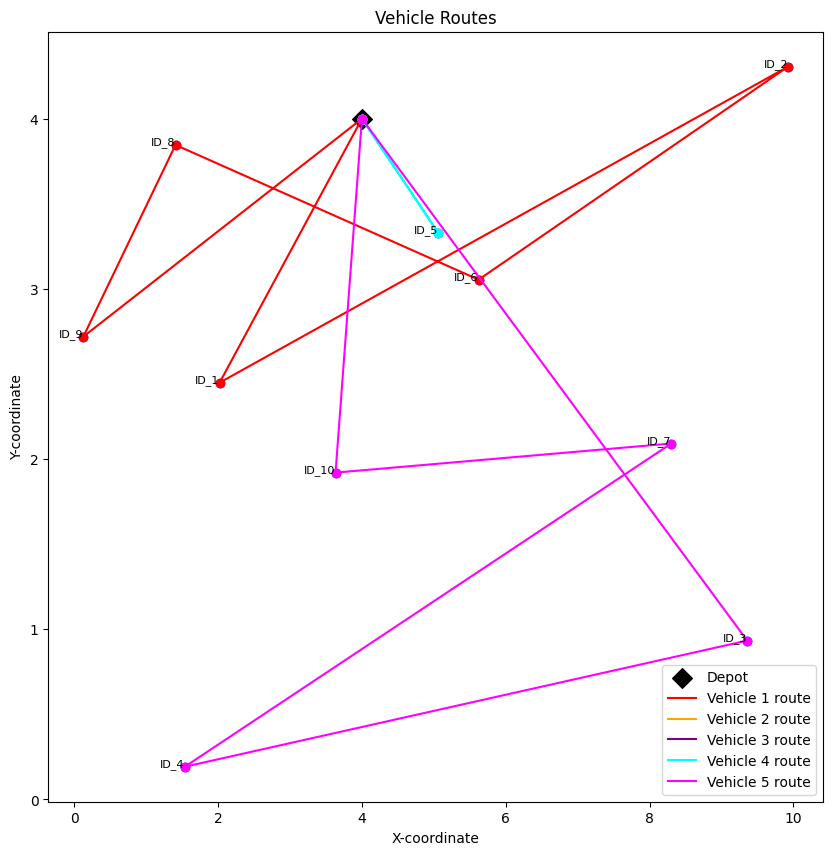

In [17]:
# Plot routes
def plot_routes(routes, depot, customer_locations):
    plt.figure(figsize=(10, 10))

    # Plot depot
    plt.scatter(*depot, color='black', marker='D', s=100, label='Depot')

    # Plot customer nodes
    for customer, (x, y) in customer_locations.items():
        plt.scatter(x, y, color='blue')
        plt.text(x, y, f"{customer_names[customer]}", fontsize=8, ha='right')
    
    # Define colors for different vehicles
    colors = ['red', 'orange', 'purple', 'cyan', 'magenta', 'black', 'green']

    # Plot routes
    for k, route in enumerate(routes):
        color = colors[k % len(colors)]  # Cycle through colors for each vehicle

        # Start the route from the depot
        x_values = [depot[0]] + [customer_locations[i][0] for i, j in route] + [depot[0]]
        y_values = [depot[1]] + [customer_locations[i][1] for i, j in route] + [depot[1]]

        plt.plot(x_values, y_values, color=color, marker='o')
        plt.plot([], [], color=color, label=f'Vehicle {k + 1} route')
    # Add legend outside the plot
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
        

    plt.title('Vehicle Routes')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()

# Display results
print("\nRESULTS\n")
print("Total distance traveled:", sum(distances[i, j, k] + pyomo.value(model.x[i, j, k]) for i in customers for j in customers for k in vehicles if i != j))

if results.solver.termination_condition == pyomo.TerminationCondition.optimal:
   
    # Display the routes
    routes = []
    for k in vehicles:
        route = [(i, j) for i in customers for j in customers if pyomo.value(model.x[i, j, k])]
        routes.append(route)
        print(f"Vehicle {k + 1} route: {[customer_names[i] for i, j in route]}")

    # Plot the routes
    plot_routes(routes, depot, customer_locations)
else:
    print("Solver did not find an optimal solution. Check the model and solver settings.")
    

In [16]:
#goods in each car
#time limit